# AO ("Ambient Occlusion") Example
This notebook does basically the same thing as running `exampleAO.py`, and then visualizes the result using [PyVista](https://docs.pyvista.org/).

## Dependencies
  * `pypr`, which relies on a `.so` file that results from compiling the Primer project using CMAKE.
    * See the "Setup" section, below.
  * [Numba](https://numba.pydata.org/): use `pip install numba` or `conda install numba`.

## Setup
Below, we must set `build_dir_path` to the directory that contains the `pypr.*.so` file. 

* This file might be called `pypr.cpython-39-x86_64-linux-gnu.so`, for example, on a 64-bit x86 Linux 64 bit system using Python 3.9.
* I am assuming that the path is `../build`, but you may need to use something different if you created a different build directory with a different name/path when you ran CMAKE.

⚠️ The name of the `.so` file will depend on your operating system, Python version, and possibly other factors, e.g. your compiler.

In [1]:
build_dir_path = r'../build' # path may be DIFFERENT depending on what you did with CMAKE

In [2]:
import sys
sys.path.append(build_dir_path)
from exampleAO import *

## Compute

### Load geometries and set up input arrays
A ray can be parameterized as:
$\mathbf{r}(t) = \mathbf{o} + t\mathbf{d}$, where:

  * $\mathbf{r} : \mathbb{R} \rightarrow \mathbb{R}^3$
  * $\mathbf{o} \in \mathbb{R}^3$ is the origin
  * $\mathbf{d} \in \mathbb{R}^3$ is the direction
  * $t \in [t_{min}, t_{max}]$ is the parameter. (If $\mathbf{d}$ is unit length, then $t$ is the distance that has been "traveled" along the ray.) 

Below we use six arrays as input to pyPrimer:

  * `orgs`: Array of $\mathbf{o}$ values (ray origins)
  * `dirs`: Array of $\mathbf{d}$ values (ray directions)
  * `tmins`, `tmaxs`: Arrays of $t_{min}$ and $t_{max}$ values
  * `trimesh_verts`: Vertex positions of input triangle mesh
  * `trimesh_idxs`: Indices into `trimesh_verts`, used to specify mesh topology and [winding order](https://cmichel.io/understanding-front-faces-winding-order-and-normals)

ℹ️ Note the presence of a quad mesh in addition to a triangle mesh. There are in fact *two* discretizations of the input geometry:

  1. A triangle mesh given to pyPrimer and used to compute the ray-surface intersections. 
  2. A quadrilateral mesh that is used when computing the ray origins and directions, and to represent the final simulation result.

In [3]:
flt_t = np.float32
int_t = np.int32

# load quadmesh
quadmesh_filename = "example_data/boxes_quadmesh.obj"
quadmesh_vtxs, quadmesh_idxs = read_obj(quadmesh_filename,4)
samps_per_patch = 64 # TODO: read this from a config file

np.random.seed()

# JIT warmup (for Numba)
num_warmup_verts = 4
num_warmup_rands = 4*num_warmup_verts*samps_per_patch 
create_rays(quadmesh_vtxs[0:num_warmup_verts], samps_per_patch) 

# Run our actual computation after the warmup
orgs, dirs, tmins, tmaxs = create_rays(quadmesh_vtxs, samps_per_patch)

# load triangle mesh
trimesh_verts = read_arr_of_vecs("example_data/boxes_trimesh.vertices",3,flt_t)
trimesh_idxs = read_arr_of_vecs("example_data/boxes_trimesh.indices",3,int_t)

### Create context
Here, we initialize pyPrimer and feed it our triangle mesh.

In [4]:
pypr.context_create()
mesh=pypr.create_mesh(0,trimesh_verts,trimesh_idxs)
model=pypr.create_model([mesh])

#pypr: new context starting up...
currently ignoring context type; always using offload to owl
#pypr: creating mesh...
#pypr:  -> found 800 vertices
#pypr:  -> found 1200 indices


### Compute ray-geometry intersection
Note that we pre-allocate the output arrays `hit_ints` and `hit_floats` here. They are filled whne `model.trace` is called.

In [5]:
assert orgs.shape[0] == dirs.shape[0]
num_rays = orgs.shape[0]
hit_ints=np.ndarray((num_rays,3),dtype=int_t)
hit_floats=np.ndarray((num_rays,3),dtype=flt_t)
model.trace(orgs,dirs,tmins,tmaxs,hit_ints,hit_floats)

stride_hit_t=12
stride_hit_primID=12


### Process the result of the ray-geometry intersection
The "ray tracing" step is now complete, and now we process the results using `integrate_patches` in order to arrive at a numerical solution to our original problem. 

  * Even though the *triangle*-based discretization of our simulation geometry was used during the ray tracing step, our solution is expressed as a floating-point value per patch of the *quadrilateral*-based discretization.

In [6]:
# get the number of surface patches and their numeric type
num_patches, vtx_dtype = get_patch_num_type(quadmesh_vtxs) 

# Jit warmup (for numba)
num_hits = hit_ints.shape[0]
assert num_hits % num_patches == 0
num_rays_per_patch = num_hits // num_patches # integer division
num_warmup_patches = 1
num_warmup_hits = num_warmup_patches*num_rays_per_patch
patch_values = integrate_patches(hit_ints[0:num_warmup_hits], num_warmup_patches, vtx_dtype)

# Run our actual computation after the warmup
patch_values = integrate_patches(hit_ints, num_patches, vtx_dtype)

## Visualization

ℹ️ The [PyVista package](https://docs.pyvista.org/) is a required dependency for visualiation.
  * Install with `conda install -c conda-forge pyvista` or `pip install pyvista`

In [7]:
import pyvista as pv

In [8]:
nodecount_col = 4*np.ones((quadmesh_idxs.shape[0],1),dtype=quadmesh_idxs.dtype)
# Concatenation is necessary because PyVista assumes 
# columns start with the number of nodes per face
faces = np.concatenate([nodecount_col,quadmesh_idxs],axis=1) 
faces = faces.flatten()
surf = pv.PolyData(quadmesh_vtxs, faces)
surf.cell_data['occluded_fraction']   =  patch_values

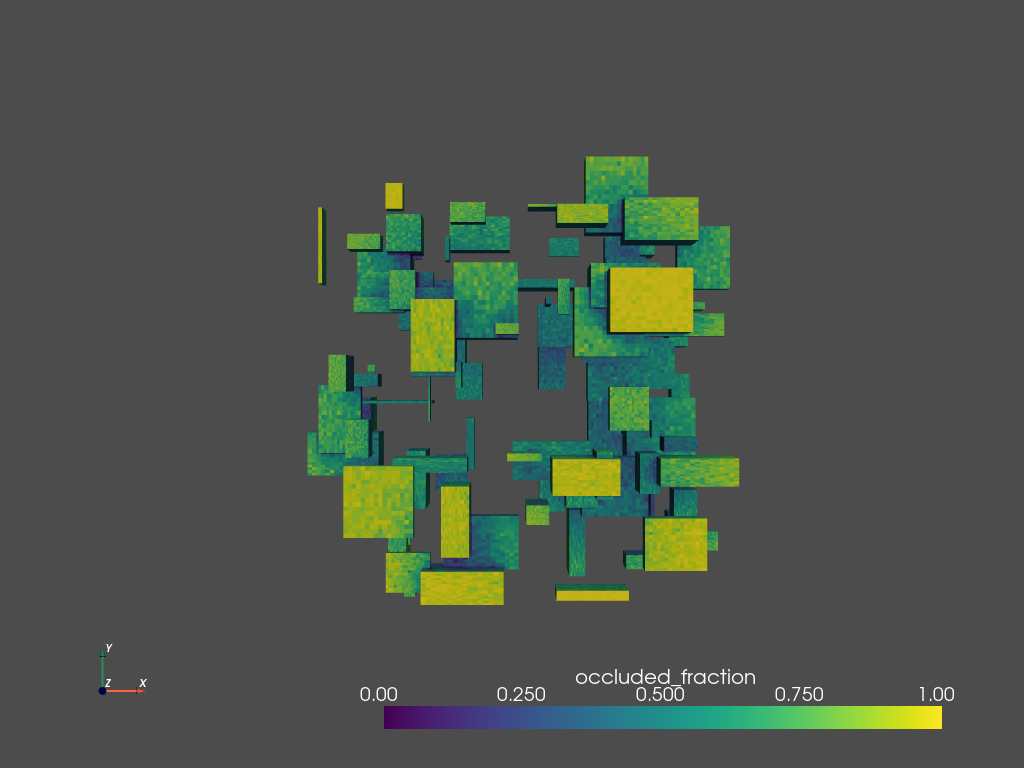

In [10]:
p = pv.Plotter()
p.show_axes() 
p.add_mesh(surf,scalars='occluded_fraction')
p.view_xy()
p.show(screenshot='pyvistatest.png')